In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
#Data paths
data_dir_train = 'data/Training data'
data_dir_val = 'data/Validation data'
data_dir_test = 'data/Test data'

In [5]:
#Module parametres
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4238 files belonging to 3 classes.


In [24]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_val,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 300 files belonging to 3 classes.


In [25]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 707 files belonging to 3 classes.


In [26]:
class_names = train_ds.class_names
print(class_names)

['Elephant', 'Panda', 'Tiger']


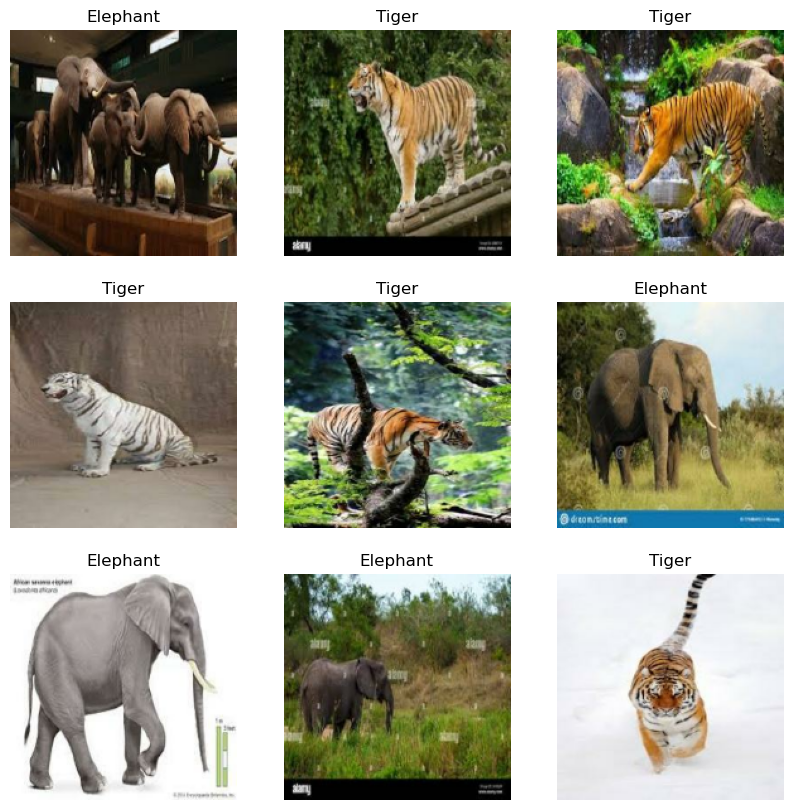

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [28]:

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [29]:
#Standarize data
normalization_layer = layers.Rescaling(1./255)

In [31]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [32]:
num_classes = len(class_names)
#Model layers
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [35]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
133/133 [==============================] - 57s 416ms/step - loss: 0.5873 - accuracy: 0.7596 - val_loss: 0.5777 - val_accuracy: 0.7933
Epoch 2/10
133/133 [==============================] - 50s 378ms/step - loss: 0.3102 - accuracy: 0.8872 - val_loss: 0.5373 - val_accuracy: 0.8067
Epoch 3/10
133/133 [==============================] - 42s 312ms/step - loss: 0.2179 - accuracy: 0.9212 - val_loss: 0.5426 - val_accuracy: 0.8233
Epoch 4/10
133/133 [==============================] - 41s 310ms/step - loss: 0.1539 - accuracy: 0.9460 - val_loss: 0.3960 - val_accuracy: 0.8600
Epoch 5/10
133/133 [==============================] - 41s 305ms/step - loss: 0.0991 - accuracy: 0.9655 - val_loss: 0.5980 - val_accuracy: 0.8467
Epoch 6/10
133/133 [==============================] - 40s 303ms/step - loss: 0.0760 - accuracy: 0.9705 - val_loss: 0.9086 - val_accuracy: 0.7867
Epoch 7/10
133/133 [==============================] - 41s 306ms/step - loss: 0.0389 - accuracy: 0.9856 - val_loss: 0.6959 - val_ac

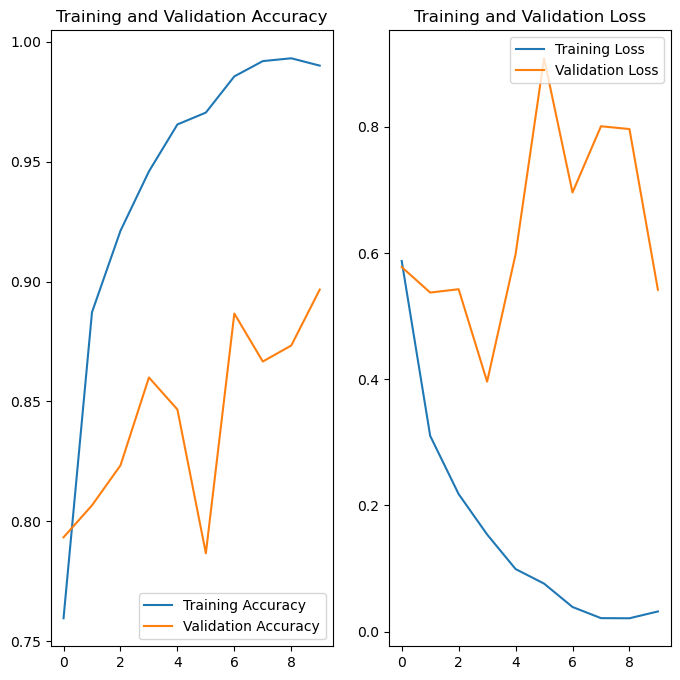

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

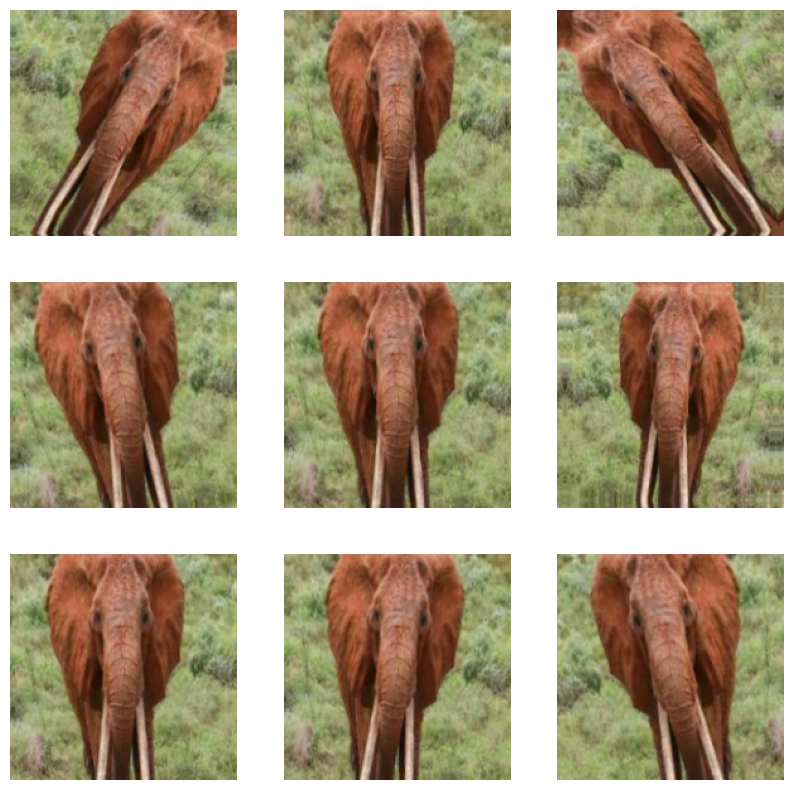

In [39]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [40]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [43]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [44]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
133/133 [==============================] - 51s 374ms/step - loss: 0.6523 - accuracy: 0.7305 - val_loss: 0.7400 - val_accuracy: 0.7033
Epoch 2/15
133/133 [==============================] - 47s 353ms/step - loss: 0.4251 - accuracy: 0.8292 - val_loss: 0.6061 - val_accuracy: 0.7967
Epoch 3/15
133/133 [==============================] - 47s 351ms/step - loss: 0.3679 - accuracy: 0.8608 - val_loss: 0.3760 - val_accuracy: 0.8600
Epoch 4/15
133/133 [==============================] - 47s 356ms/step - loss: 0.3215 - accuracy: 0.8782 - val_loss: 0.5013 - val_accuracy: 0.8433
Epoch 5/15
133/133 [==============================] - 47s 353ms/step - loss: 0.3189 - accuracy: 0.8813 - val_loss: 0.5062 - val_accuracy: 0.8367
Epoch 6/15
133/133 [==============================] - 48s 362ms/step - loss: 0.2828 - accuracy: 0.8955 - val_loss: 0.5206 - val_accuracy: 0.8233
Epoch 7/15
133/133 [==============================] - 50s 375ms/step - loss: 0.2720 - accuracy: 0.8933 - val_loss: 0.3478 - val_ac

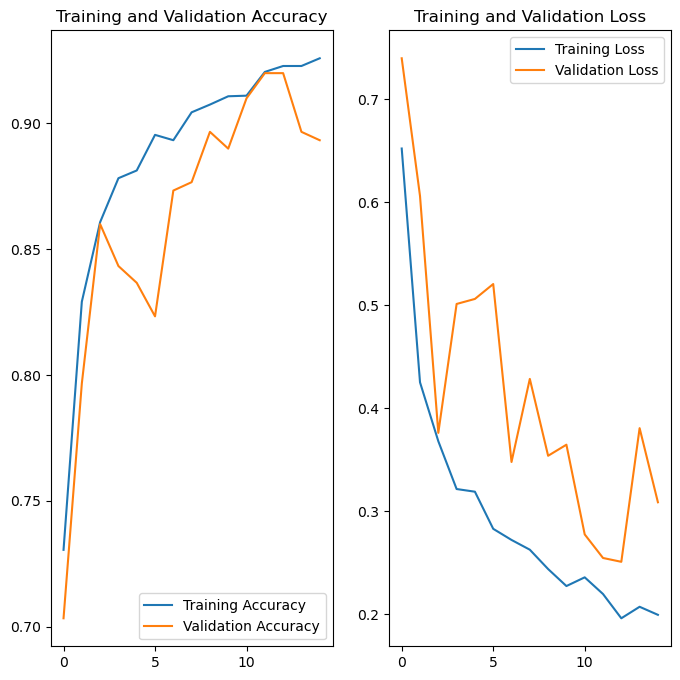

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [47]:
#Testing model on test data
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy:', accuracy)

23/23 [==============================] - 2s 78ms/step - loss: 0.2370 - accuracy: 0.9208
Test accuracy: 0.9207921028137207


In [52]:
model.save('model3a.h5')

In [ ]:
import tkinter as tk
from tkinter import filedialog
from PIL import ImageTk, Image
import tensorflow as tf
import numpy as np

#Wczytanie liczby klas
test_ds = tf.keras.utils.image_dataset_from_directory(
  'data/Test data',
      image_size=(180, 180),
  batch_size=32)

class_names = test_ds.class_names
print(class_names)
num_classes = len(class_names)

# Definicja modelu
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

# Wczytanie wag modelu
model.load_weights('model3a.h5')

# Inicjalizacja GUI
root = tk.Tk()

# Funkcja do wczytywania obrazu i dokonywania predykcji
def predict_image():
    file_path = filedialog.askopenfilename()
    img = tf.keras.utils.load_img(
    file_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

    image = Image.open(file_path).resize((img_width, img_height))
    image = image.convert("RGB")
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    # Tworzenie nowego okna dla wyświetlenia wyników
    result_window = tk.Toplevel(root)
    result_window.title("Prediction Result")

    # Wyświetlanie przewidywanego gatunku zwierzęcia
    class_label_text = "Predicted Class: {}".format(class_names[np.argmax(score)])
    class_label_label = tk.Label(result_window, text=class_label_text)
    class_label_label.pack()

    # Wyświetlanie pewności predykcji
    confidence_text = "Confidence: {:.2f}%".format(100 * np.max(score))
    confidence_label = tk.Label(result_window, text=confidence_text)
    confidence_label.pack()

    # Wyświetlanie wczytanego obrazu
    image_display = ImageTk.PhotoImage(Image.open(file_path).resize((300, 300)))
    image_label = tk.Label(result_window, image=image_display)
    image_label.image = image_display
    image_label.pack()

# Przycisk do wczytywania obrazu
upload_button = tk.Button(root, text="Upload Image", command=predict_image)
upload_button.pack()

# Uruchomienie GUI
root.mainloop()

In [1]:
import tensorflow as tf
